<a href="https://colab.research.google.com/github/toru-matano/Random-Forest-Tensorflow-test/blob/main/random_forest_sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
 # カリフォルニア住宅価格のデータセット
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['Price'] = housing.target
df.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
df = df[df['HouseAge'] < df['HouseAge'].max()]
df = df[df['Price'] < df['Price'].max()]

# 説明変数
X = df.drop(['Price'], axis=1)
# 目的変数
y = df['Price']

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
#標準化
X = scaler.fit_transform(X)

X = X.astype(np.float32)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape)


(14857, 8) (3715, 8)


In [6]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [7]:
from sklearn.metrics import mean_squared_error

model_train_pred = model.predict(X_train)
model_train_mse = mean_squared_error(y_train, model_train_pred)
model_train_rmse = np.sqrt(model_train_mse)

model_test_pred = model.predict(X_test)
model_test_mse = mean_squared_error(y_test, model_test_pred)
model_test_rmse = np.sqrt(model_test_mse)

print(f'MSE:{model_train_mse, model_test_mse}')
print(f'RMSE:{model_train_rmse, model_test_rmse}')

MSE:(0.02816093174822743, 0.1983376559706036)
RMSE:(0.1678121918938771, 0.445351160288826)


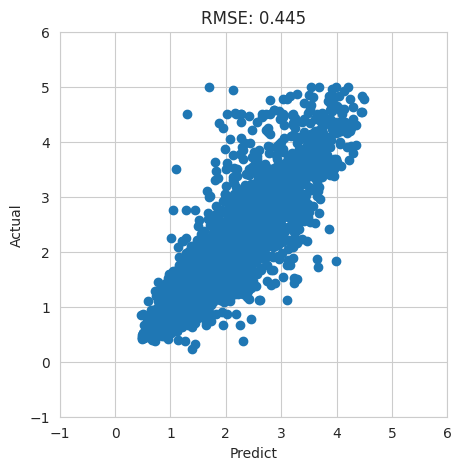

In [ ]:
plt.figure(figsize=(5,5))
plt.xlim(-1, 6)
plt.ylim(-1, 6)
plt.plot(model.predict(X_test), y_test, 'o')
plt.title('RMSE: {:.3f}'.format(model_test_rmse))
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.show()

In [ ]:
importance = model.feature_importances_
columns = df.drop(['Price'], axis=1).columns

for i, feature in enumerate(columns):
  print(f'{feature:10s} : {importance[i]:>.6f}')

MedInc     : 0.471811
HouseAge   : 0.050328
AveRooms   : 0.047698
AveBedrms  : 0.031884
Population : 0.035327
AveOccup   : 0.131176
Latitude   : 0.113225
Longitude  : 0.118552


In [ ]:
!pip install skl2onnx
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

import onnxruntime as ort

initial_type = [('float_input', FloatTensorType([None, 8]))]
onnx_model = convert_sklearn(model, initial_types=initial_type)

In [ ]:
save_fname = "RandomForestModel.onnx"
with open(save_fname, "wb") as f:
  f.write(onnx_model.SerializeToString())


In [ ]:
session = ort.InferenceSession(save_fname, providers=["CPUExecutionProvider"])

input_name = session.get_inputs()[0].name
label_name = session.get_outputs()[0].name

pred_onx = session.run(
    [label_name],
    {input_name: X_test.astype(np.float32)}
)[0]

pred_onx

array([[1.2137103],
       [1.6232   ],
       [1.2311196],
       ...,
       [2.2221496],
       [3.9214997],
       [2.0158205]], dtype=float32)